# Comparison of Machine Learning Models for Sentiment Analysis
- Random Forest
- Support Vector Classification (SVC)
- Multinomial Naive Bayes
- Logistic Regression

In [1]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, get_scorer, f1_score,roc_auc_score,precision_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
#from xgboost import XGBClassifier # maybe excluse this

In [2]:
# load data
df = pd.read_csv('resources/data set/tweet_sentiments.csv')
df.head()

,text,neg,neu,pos,compound,sentiment
0,a cruise missile fired by the russian army fel...,0.265,0.735,0.000,-0.5574,negative
1,spread and share you can help ukraine,0.000,0.505,0.495,0.5994,positive
2,footage of the airport bombing in ivano franki...,0.000,1.000,0.000,0.0000,neutral
3,now this is wrong absolutely wrong for ...,0.282,0.718,0.000,-0.9117,negative
4,rd mechanized brigade continues to suffer ...,0.437,0.563,0.000,-0.7351,negative


In [3]:
# check the count of the sent_score where Negative, Positive, Neutral
df["sentiment"].value_counts()

negative    187872
positive    170406
neutral      82211
Name: sentiment, dtype: int64

In [4]:
# Dropping all neutral sentiments to generalize the model
df = df[df["sentiment"]!="neutral"]

In [5]:
# Creating encoded column for sentiments by using .factorize() function in panda encode the object as an 
#enumerated type or categorical variable. 
df["sent_score"]=df["sentiment"].factorize()[0]
df.head()

,text,neg,neu,pos,compound,sentiment,sent_score
0,a cruise missile fired by the russian army fel...,0.265,0.735,0.000,-0.5574,negative,0
1,spread and share you can help ukraine,0.000,0.505,0.495,0.5994,positive,1
3,now this is wrong absolutely wrong for ...,0.282,0.718,0.000,-0.9117,negative,0
4,rd mechanized brigade continues to suffer ...,0.437,0.563,0.000,-0.7351,negative,0
5,the world must act immediately is at stake ...,0.226,0.730,0.044,-0.8173,negative,0


In [10]:
sample_df = df.groupby('sent_score').sample(frac=.01)
sample_df.shape

(3583, 7)

In [11]:
# Standardize sentiment score distribution
sample_df["sent_score"].value_counts(normalize=True)

0    0.524421
1    0.475579
Name: sent_score, dtype: float64

In [12]:
# define independent and dependent variables
X=sample_df['text']
y=sample_df['sent_score']

In [13]:
# split the data into train and test
X_train, X_test, y_train, y_test=train_test_split(X, y, train_size=.8, random_state=42)

## TF-IDF (Term Frequency-Inverse Document Frequency)
It measures how many times a term exists in a document and gives less weight to most frequent terms, as those terms will probably be unhelpful in categorizing the dataset.

In [14]:
# Instantiate and fit TfidfVectorizer 
vectorizer = TfidfVectorizer(min_df=3,sublinear_tf=True,encoding="latin-1", ngram_range=(1,2),
                             stop_words='english')

In [15]:
# Transform text into numeric vectors
X_train_tf= vectorizer.fit_transform(X_train.reset_index()["text"]).toarray()
X_test_tf = vectorizer.transform(X_test.reset_index()["text"]).toarray()

In [16]:
X_train_tf.shape

(2866, 4048)

## Compare Models

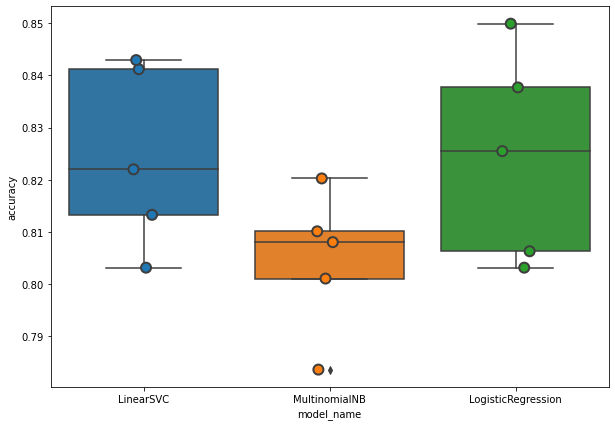

In [23]:
# run data over various models
models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_tf, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
plt.subplots(figsize = (10,7))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=10, jitter=True, edgecolor="gray", linewidth=2)

plt.show()

In [24]:
# check the mean of the accuracy for each model
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC             0.824502
LogisticRegression    0.824502
MultinomialNB         0.804604
Name: accuracy, dtype: float64

## Select the best model and implement it

In [ ]:
# import os
# # Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# # For example:
# # spark_version = 'spark-3.0.3'
# spark_version = 'spark-3.0.3'
# os.environ['SPARK_VERSION']=spark_version

# # Install Spark and Java
# !apt-get update
# !apt-get install openjdk-11-jdk-headless -qq > /dev/null
# !wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
# !tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
# !pip install -q findspark

# # Set Environment Variables
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
# #os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"
# os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# # Start a SparkSession
# import findspark
# findspark.init()

In [ ]:
# # Start Spark session
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.appName("Twitter_Ukraine").getOrCreate()
# # import textBlob
# from textblob import TextBlob

In [ ]:
# # Read in data from S3 Buckets **** IF RUNNING FROM COLAB, WE MIGHT HAVE TO USE AN AWS BUCKET OR SIMILAR ****
# from pyspark import SparkFiles
# url ="https://bootcamp-team-project.s3.us-west-2.amazonaws.com/mock_data.csv"
# spark.sparkContext.addFile(url)
# df = spark.read.csv(SparkFiles.get("mock_data.csv"), sep=",", header=True)

# # Show DataFrame
# df.show()

In [ ]:
# Import functions
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer

In [ ]:
# create a copy and write sentiment polarity using TextBlob
from pyspark.sql.functions import udf
data_df = df['following','followers','totaltweets','retweetcount','favorite_count','text']
sentiment = udf(lambda x: TextBlob(x).sentiment[0])
spark.udf.register("sentiment", sentiment)
data_df = data_df.withColumn('sentiment',sentiment('text').cast('double'))
data_df.show()

In [ ]:

# Binning the sentiment polarities
from pyspark.sql.types import StringType
def sentiment_bins(value):
   # try:
      if value > 0.6:
        return "ExtremePositive"
      if value > 0.3:
        return "Positive"
      if value < -0.6:
        return "ExtremeNegative"
      if value < -0.3:
        return "Negative"
      else:
        return "Neutral"
 #   except:
 #       return None

partial_func = udf(lambda x: sentiment_bins(x))
data_df = data_df.withColumn("sentiment_bins", partial_func(data_df.sentiment))

data_df.show()


In [ ]:
# Create all the features to the data set
# pos_neg_to_num = StringIndexer(inputCol='sentiment_bins',outputCol='label')
# tokenizer = Tokenizer(inputCol="text", outputCol="token_text")
# stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
# hashingTF = HashingTF(inputCol="stop_tokens", outputCol='hash_token')
# idf = IDF(inputCol='hash_token', outputCol='idf_token')

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector
# Create feature vectors
clean_up = VectorAssembler(inputCols=['idf_token', 'sentiment'], outputCol='features')

In [ ]:
# Create and run a data processing Pipeline
from pyspark.ml import Pipeline
data_prep_pipeline = Pipeline(stages=[pos_neg_to_num, tokenizer, stopremove, hashingTF, idf, clean_up])

In [ ]:
# Fit and transform the pipeline
cleaner = data_prep_pipeline.fit(data_df)
cleaned = cleaner.transform(data_df)

In [ ]:
# Show labels and resulting features
cleaned.select(["label", "features"]).show()

In [ ]:
# Break data down into a training set and a testing set
training, testing = cleaned.randomSplit([0.7, 0.3], 21)

In [ ]:
from pyspark.ml.classification import NaiveBayes
# Create a Naive Bayes model and fit training data
nb = NaiveBayes()
predictor = nb.fit(training)

In [ ]:
# Transform the model with the testing data
test_results = predictor.transform(testing)
test_results.show(5)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
acc_eval = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction')
acc = acc_eval.evaluate(test_results)
print('Accuracy of model at predicting sentiment was: %f' % acc)